In [136]:
%pylab inline
from em_examples.HarmonicVMDCylWidget import HarmonicVMDCylWidget
from em_examples.BiotSavart import BiotSavartFun
from SimPEG import Utils

Populating the interactive namespace from numpy and matplotlib


In [137]:
vmd = HarmonicVMDCylWidget()

In [138]:
h1 = 6
h2 = 6
h3 = 6
Sigma0 = 1e-8
Sigma1 = 1e-1
Sigma2 = 1e-3
Sigma3 = 1e-3
z = 0.
rxOffset = 2.1
Frequency = np.logspace(2, 5, 31)
bType = "bSecondary"
m = vmd.setThreeLayerParam(h1=h1, h2=h2, sig0=Sigma0, sig1=Sigma1, sig2=Sigma2, sig3=Sigma3)
srcLoc = np.array([0., 0., z])
rxLoc = np.array([[rxOffset, 0., z]])
dpred = vmd.simulate(srcLoc, rxLoc, Frequency)
vmd.getFields(bType=bType)

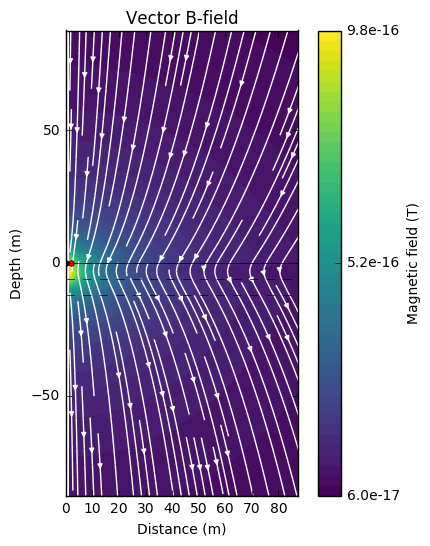

In [139]:
vmd.plotField()

In [146]:
import scipy.sparse as sp
from scipy.constants import mu_0

Gz = BiotSavartFun(vmd.mesh, rxLoc, component='z')
Gx = BiotSavartFun(vmd.mesh, rxLoc, component='x')
src = vmd.srcList[0]
Jy = Utils.sdiag(vmd.prb.sigma) * vmd.mesh.aveE2CC*vmd.f[:, "e"]

dataz = (Gz.dot(np.vstack((np.ones_like(Jy), Jy, np.ones_like(Jy))))).flatten()
vmd.getData(bType=bType)

In [147]:
from ipywidgets import *

<function __main__.footprint>

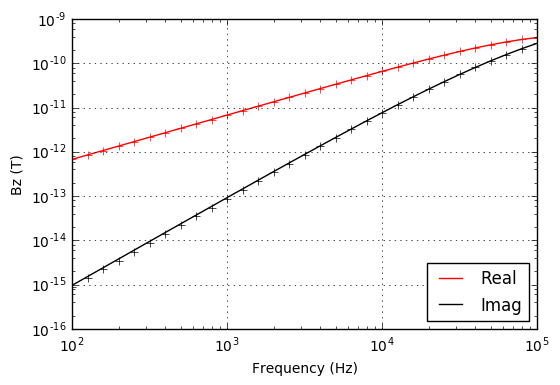

In [148]:
def footprint(r):
# r = 100.
    actind = (abs(vmd.mesh.gridCC[:,0]) < r) & (vmd.mesh.gridCC[:,2] > -r) 
    dataz_footprint = (Gz[:,np.r_[actind, actind, actind]].dot(np.vstack((np.ones_like(Jy[actind,:]), Jy[actind,:], np.ones_like(Jy[actind,:]))))).flatten()
    plt.loglog(Frequency, abs(dataz.imag), 'r')
    plt.loglog(Frequency, abs(dataz.real), 'k')
    plt.loglog(Frequency, abs(dataz_footprint.imag), 'r+')
    plt.loglog(Frequency, abs(dataz_footprint.real), 'k+')
    plt.legend(("Real", "Imag"), loc=4)
    plt.grid(True)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Bz (T)")    
# plt.loglog(Frequency, -vmd.Bz.imag, 'r.')
# plt.loglog(Frequency, -vmd.Bz.real, 'k.')
interact(footprint, r=FloatText(value=100., description="Footprint (m)"))

In [50]:
# vmd.getData(bType=bType)
# plt.loglog(Frequency, -datax.imag/10, 'r')
# plt.loglog(Frequency, -vmd.Bx.imag, 'r.')
# plt.loglog(Frequency, -datax.real/10, 'k')
# plt.loglog(Frequency, -vmd.Bx.real, 'k.')